In [1028]:
import numpy as np
import pandas as pd

In [1029]:
car_df = pd.read_csv('../dataset/car_fuel_efficiency.csv')

In [1030]:
car_df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [1031]:
car_df = car_df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

EDA

<Axes: >

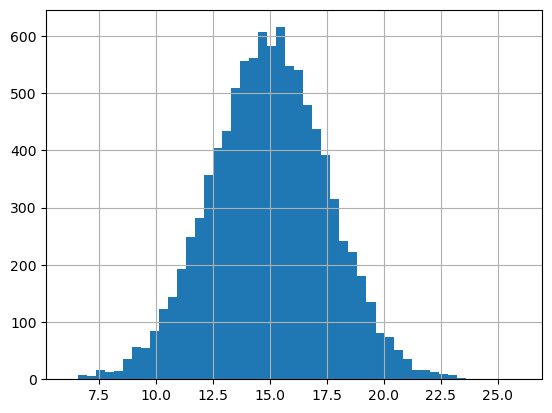

In [1032]:
car_df['fuel_efficiency_mpg'].hist(bins=50)

# fuel efficiency does not have a long tail, in fact it is in normal distribution

In [1033]:
car_df.isna().sum()

# horsepower column has missing values

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [1034]:
car_df['horsepower'].median()

149.0

In [1035]:
def prepare_X(df, fillna = 0):

    df = df.copy()

    df['horsepower'] = df['horsepower'].fillna(fillna)

    return df

def train_linear_regression(X, y):

    ones = np.ones(X.shape[0])

    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)

    XTX_inv = np.linalg.inv(XTX)
    
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):

    error_sq = (y - y_pred) ** 2

    es_mean = error_sq.mean()

    return np.sqrt(es_mean)

In [1036]:
n = car_df.shape[0]

n_val = int(n * 0.2)

n_test = int(n * 0.2)

n_train = n - (n_val + n_test) 

In [1037]:
idx = np.arange(n)

np.random.seed(42)

np.random.shuffle(idx)

In [1038]:
df_train = car_df.iloc[idx[:n_train]]

df_val = car_df.loc[idx[n_train:n_train+n_val]]

df_test = car_df.loc[idx[n_train+n_val:]]

y_train = df_train['fuel_efficiency_mpg']

y_val = df_val['fuel_efficiency_mpg']

y_test = df_test['fuel_efficiency_mpg']

In [1039]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [1040]:
len(y_train), len(y_val), len(y_test)

(5824, 1940, 1940)

In [1041]:
del df_train['fuel_efficiency_mpg']

del df_val['fuel_efficiency_mpg']

del df_test['fuel_efficiency_mpg']

In [1042]:
X_train = df_train.copy().fillna(0)

w0, w = train_linear_regression(X_train, y_train)

X_val = df_val.fillna(0)

y_pred =  w0 + X_val.dot(w)

rmse_zero = rmse(y_val, y_pred)

In [1043]:
len(X_train), len(y_train)

(5824, 5824)

In [1044]:
train_hp_mean = df_train['horsepower'].mean()

X_train = prepare_X(df_train, df_train['horsepower'].mean())

w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, df_val['horsepower'].mean())

y_pred =  w0 + X_val.dot(w)

rmse_mean = rmse(y_val, y_pred)

In [1045]:
round(rmse_zero, 3), round(rmse_mean, 3)

# mean is better

(np.float64(0.517), np.float64(0.464))

In [1046]:
def train_linear_regression_reg(X, y, r=0.01):

    ones = np.ones(X.shape[0])

    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)

    XTX = XTX + r * np.eye(XTX.shape[0]) 

    XTX_inv = np.linalg.inv(XTX)

    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [1047]:
rmse_list = []

r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

X_train = prepare_X(df_train)

X_val = prepare_X(df_val)

for r in r_list:

    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred =  w0 + X_val.dot(w)

    rmse_val = round(rmse(y_val, y_pred), 2)

    rmse_list.append(rmse_val)

    print(r, rmse_val)


rmse_dict = dict(zip(r_list, rmse_list))

min(rmse_dict.items(), key=lambda x: x[1])

# Best r = 0

0 0.52
0.01 0.52
0.1 0.52
1 0.52
5 0.52
10 0.52
100 0.52


(0, np.float64(0.52))

In [1048]:
scores = []

idx = np.arange(n)

for seed in range(10):
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = car_df.iloc[idx[:n_train]].copy()
    df_val = car_df.iloc[idx[n_train:n_train+n_val]].copy()
    df_test = car_df.iloc[idx[n_train+n_val:]].copy()

    y_train = df_train.pop('fuel_efficiency_mpg')
    y_val = df_val.pop('fuel_efficiency_mpg')
    y_test = df_test.pop('fuel_efficiency_mpg')

    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    scores.append(rmse(y_val, y_pred))


In [1049]:
round(np.std(scores), 3)

np.float64(0.006)

In [1050]:
idx = np.arange(n)

np.random.seed(9)

np.random.shuffle(idx)

df_train = car_df.iloc[idx[:n_train]]

df_val = car_df.iloc[idx[n_train:n_train+n_val]]

df_test = car_df.iloc[idx[n_train+n_val:]]

In [1051]:
df_train_full = pd.concat([df_train, df_val]).reset_index(drop=True)

y_train_full = df_train_full['fuel_efficiency_mpg']

y_test = df_test['fuel_efficiency_mpg']

In [1052]:
del df_train_full['fuel_efficiency_mpg']

del df_test['fuel_efficiency_mpg']

In [1053]:
X_train = prepare_X(df_train_full)

w0, w = train_linear_regression_reg(X_train, y_train_full, r=0.001)

X_test = prepare_X(df_test)

y_pred =  w0 + X_test.dot(w)

rmse(y_test, y_pred)

np.float64(0.5156261299185867)